## Business Context

With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

In [1294]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

### Load the Past Data and New Data

In [1295]:
past_data = pd.read_csv(r'C:\Users\patel\OneDrive\Desktop\DataSets\Hotel Cancellation Data/INNHotelsGroup_pastdata.csv')
new_data  = pd.read_csv(r'C:\Users\patel\OneDrive\Desktop\DataSets\Hotel Cancellation Data/INNHotelsGroup_newdata.csv')

In [1296]:
# Lets check their shape
past_data.shape

(27093, 12)

In [1297]:
new_data.shape

(3583, 11)

In [1298]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


In [1299]:
past_data.tail(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
27091,INNHG_128125,68,Online,1,131.40,2,0,2022-06-30,0,2,Canceled,No
27092,INNHG_128126,158,Online,1,90.95,2,1,2022-06-30,0,3,Canceled,No


In [1300]:
new_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled


In [1301]:
new_data.tail(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
3581,INNHG_131708,214,Online,0,120.90,2,0,2022-09-29,0,3,Canceled
3582,INNHG_131709,193,Online,1,93.09,2,0,2022-09-29,0,3,Canceled


#### Lets Understand exactly how many bookings were cancelled and rebooked at last moment from JAN-21 to JULY-22

In [1302]:
# Lets see how many bookings were cancelled

In [1303]:
past_data['booking_status'].value_counts(normalize=True)

booking_status
Not Canceled    0.673089
Canceled        0.326911
Name: proportion, dtype: float64

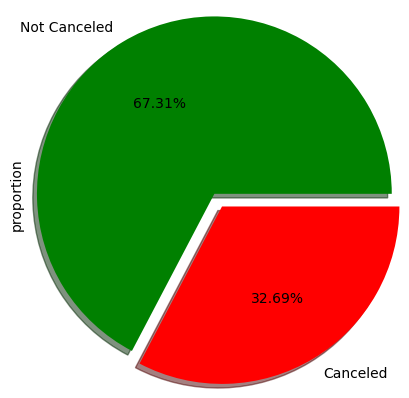

In [1304]:
past_data['booking_status'].value_counts(normalize=True).plot(kind='pie',
                                    autopct='%.2f%%',radius=1.2,colors=['green','red'],
                                    shadow=True,explode=[0,0.1])
plt.show()

In [1305]:
# Lets see how many cancelled bookings were rebooked?

book_data = past_data[past_data['booking_status']=='Canceled']

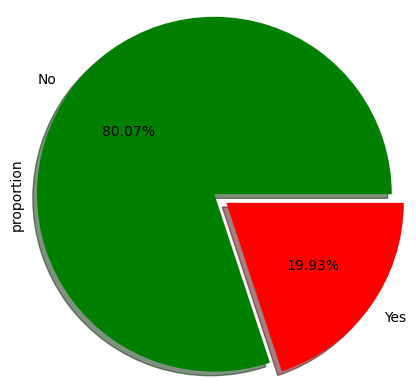

In [1306]:
book_data['rebooked'].value_counts(normalize=True).plot(kind='pie',
                                    autopct='%.2f%%',radius=1.2,colors=['green','red'],
                                    shadow=True,explode=[0,0.1])
plt.show()

Inference: Here we can see that out of all the booking ~33% bookings are being cancelled and out of these 33% only ~20% booking are rebooked. Hence the Heuristic approach is not affective at all, the inventory losses are still very high.

## Exploring the data

In [1307]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


In [1308]:
past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


In [1309]:
# Booking ID a redundant column lets make it an index.

past_data.set_index('booking_id',inplace=True)
new_data.set_index('booking_id',inplace=True)

In [1310]:
# We also need to change the data type of columns "Arrival Date" to datetime
past_data['arrival_date'] = pd.to_datetime(past_data['arrival_date'],format='%Y-%m-%d')
new_data['arrival_date'] = pd.to_datetime(new_data['arrival_date'],format='%Y-%m-%d')

In [1311]:
past_data.dtypes

lead_time                              int64
market_segment_type                   object
no_of_special_requests                 int64
avg_price_per_room                   float64
no_of_adults                           int64
no_of_weekend_nights                   int64
arrival_date                  datetime64[ns]
required_car_parking_space             int64
no_of_week_nights                      int64
booking_status                        object
rebooked                              object
dtype: object

In [1312]:
past_data.tail(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
booking_id,,,,,,,,,,,
INNHG_128125,68,Online,1,131.40,2,0,2022-06-30,0,2,Canceled,No
INNHG_128126,158,Online,1,90.95,2,1,2022-06-30,0,3,Canceled,No


### Univariate Analysis 

In [1313]:
num_cols = ['lead_time','avg_price_per_room']
cat_cols = ['market_segment_type', 'no_of_special_requests',
            'no_of_adults', 'no_of_weekend_nights','required_car_parking_space', 
            'no_of_week_nights','booking_status', 'rebooked']

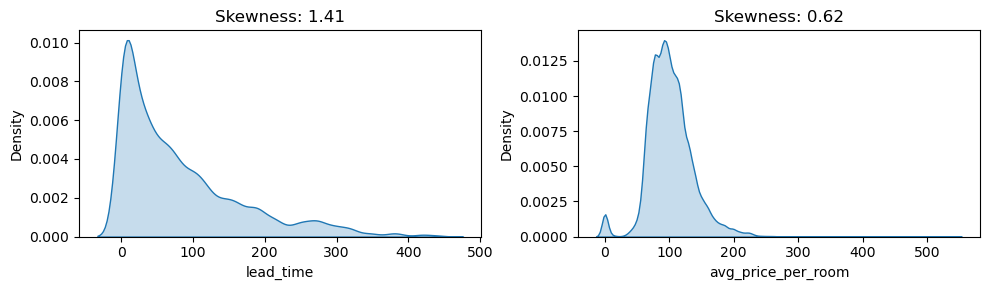

In [1314]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()
    

Inference:
* The lead time has very large values >200, which means there are bookings which have been made more than 200 days prior !!!
* There are booking with average price per room is 0?

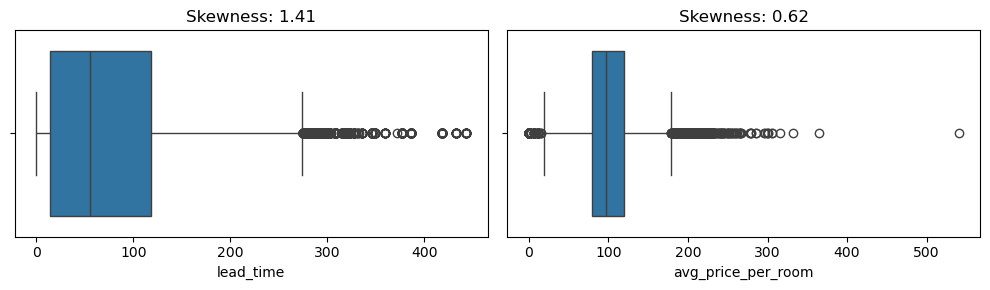

In [1315]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

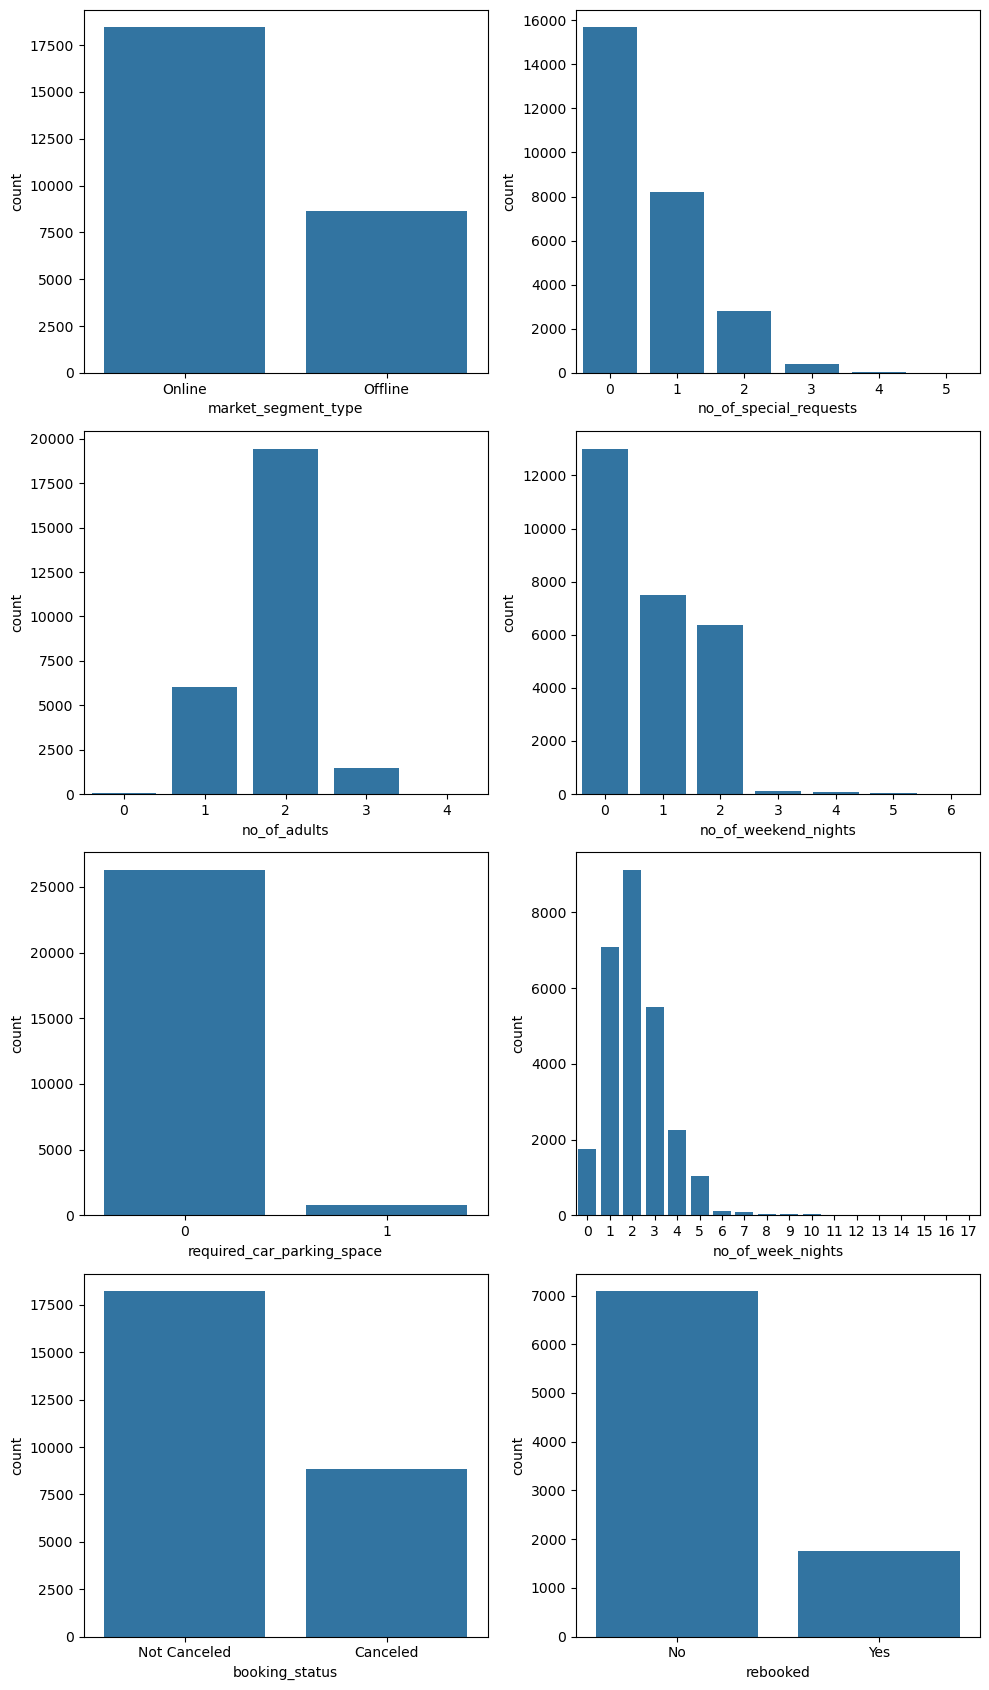

In [1316]:
t=1
plt.figure(figsize=(10,17))
for i in cat_cols:
    plt.subplot(4,2,t)
    sns.countplot(data=past_data,x=i)
    t+=1
plt.tight_layout()
plt.show()

Inference:

*

*

*

### Bivariate Analysis

In [1317]:
# Num VS Cat

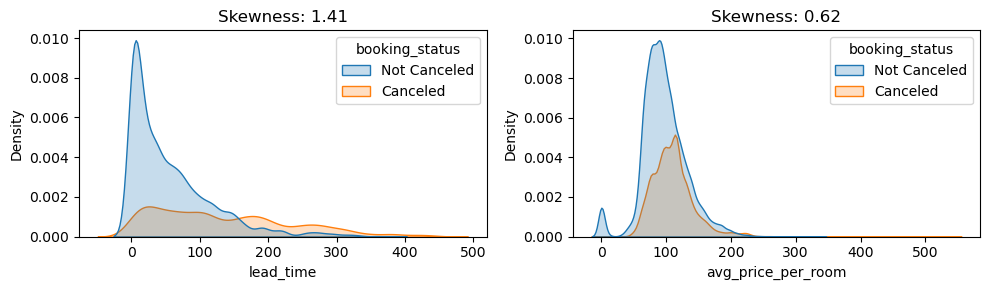

In [1318]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True,hue='booking_status')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

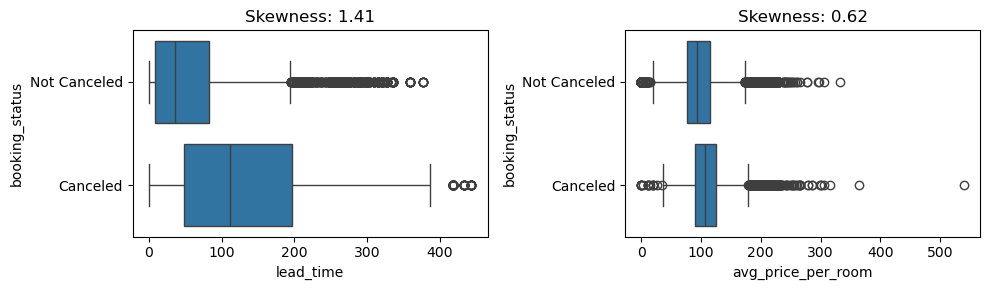

In [1319]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i,y='booking_status')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

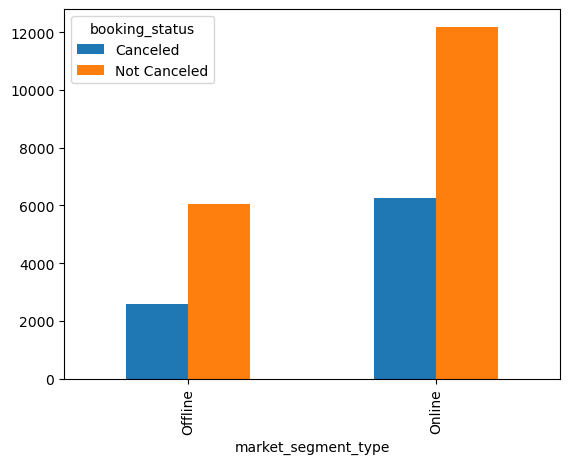

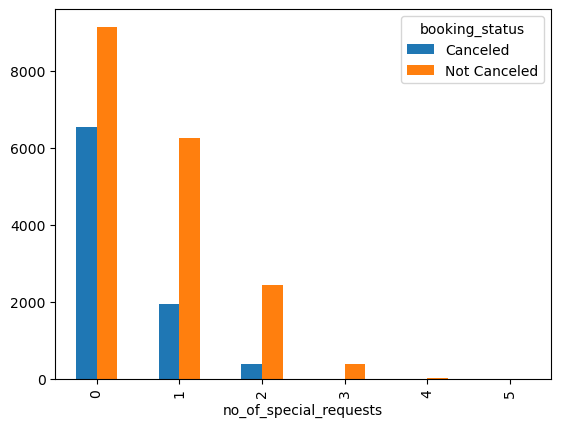

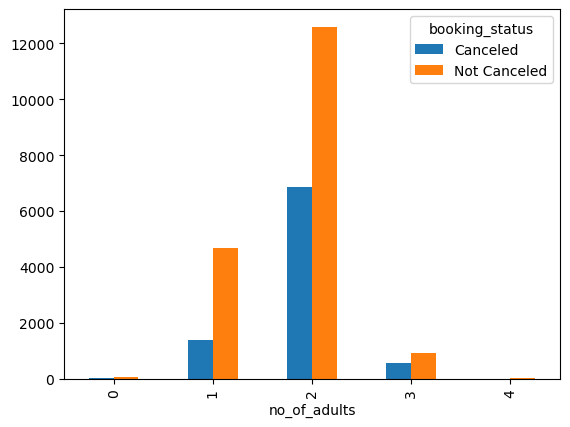

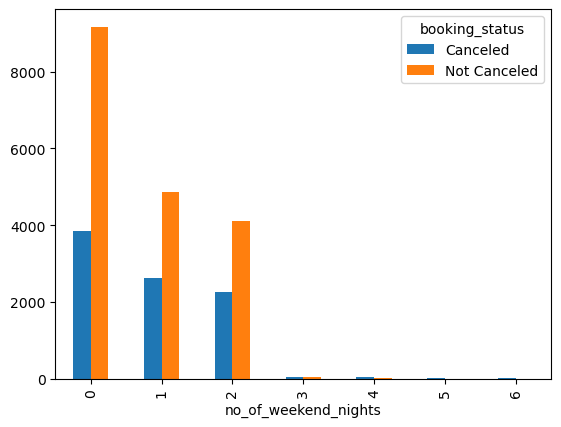

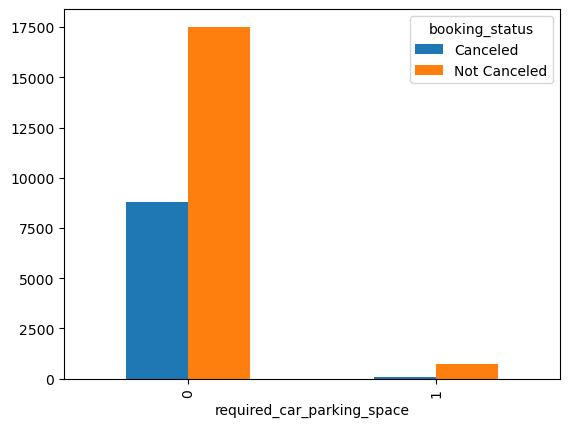

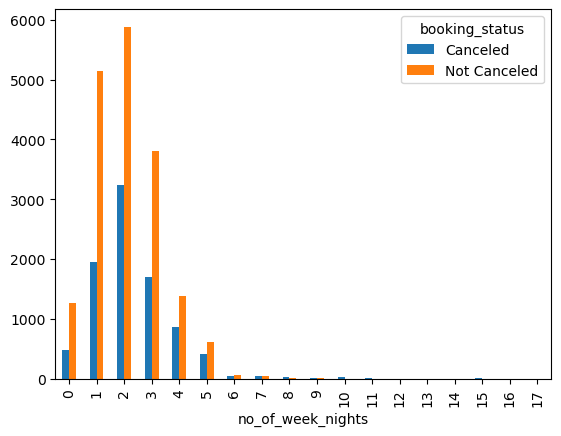

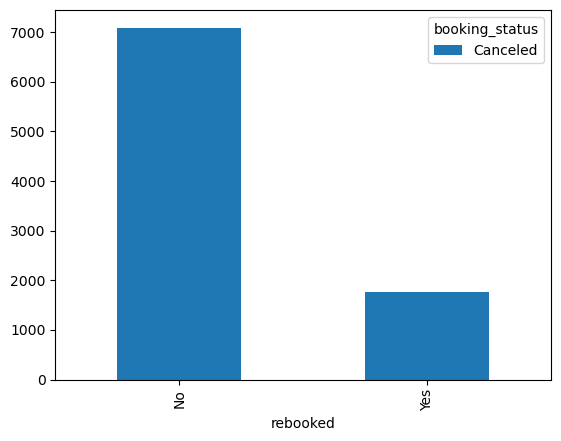

In [1320]:
# Cat vs Cat (Grouped Bar plot)

for i in cat_cols:
    if i !='booking_status':
        pd.crosstab(past_data[i],past_data['booking_status']).plot(kind='bar')
    plt.show()

### Multivariate Analysis

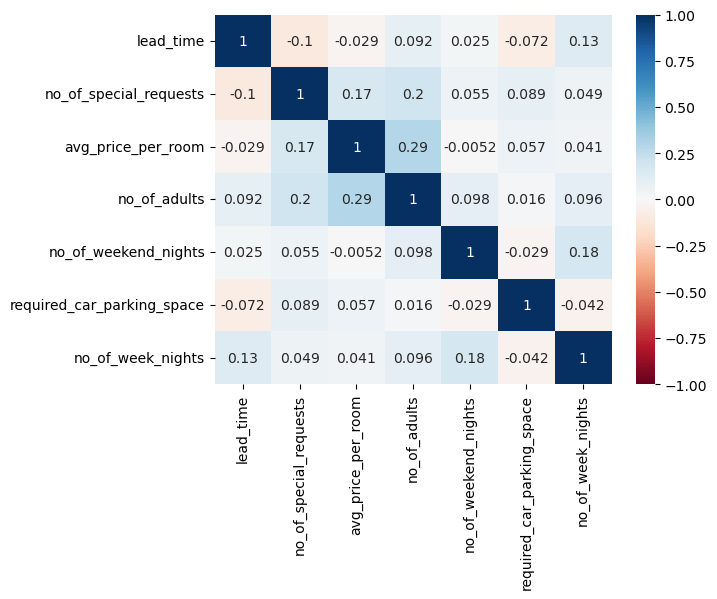

In [1321]:
sns.heatmap(past_data.corr(numeric_only=True),annot=True,cmap='RdBu',vmin=-1)
plt.show()

## Inferential Statistics

In [1322]:
# Lets statistically test the inferences that we have made.

In [1323]:
# Lead_time vs Booking Status

samp1 = past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['lead_time']

# Lets go with 2 Sample t-test
# Ho: mu1=mu2 (Lead time does not affects the booking cancelations)
# Ha: mu1!=mu2 (Lead time does affects the booking cancelations)


# Assumption 1: data must be normal (Since sample size>30 lets assume it normal)

# Assumption 2: variances must be equal
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))  #p_value less than 0.05

# Hence varainces of pop are not equal hence lets go with two sample t-test
# with unequal varainces (Welch's t-test)

print(stats.ttest_ind(samp1,samp2,equal_var=False))
# Since p_value is <0.05 we reject Ho:

LeveneResult(statistic=np.float64(3210.120590252021), pvalue=np.float64(0.0))
TtestResult(statistic=np.float64(66.84799194126163), pvalue=np.float64(0.0), df=np.float64(12138.394836237343))


In [1324]:
# Avg_room_price VS booking_status

samp1 = past_data[past_data['booking_status']=='Canceled']['avg_price_per_room']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['avg_price_per_room']

# Lets go with 2 Sample t-test
# Ho: mu1=mu2 (avg_price_per_room does not affects the booking status)
# Ha: mu1!=mu2 (avg_price_per_room does affects the booking status)


# Assumption 1: data must be normal (Since sample size>30 lets assume it normal)

# Assumption 2: variances must be equal
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))  #p_value less than 0.05

# Hence varainces of pop are not equal hence lets go with two sample t-test
# with unequal varainces (Welch's t-test)

print(stats.ttest_ind(samp1,samp2,equal_var=False))
# Since p_value is <0.05 we reject Ho:

LeveneResult(statistic=np.float64(29.227364523829735), pvalue=np.float64(6.490728476679038e-08))
TtestResult(statistic=np.float64(29.9727805387597), pvalue=np.float64(8.462441935004689e-193), df=np.float64(18575.27155776574))


In [1325]:
# All cat columns VS booking status

# chi-square test for independence

# Ho: No relation in categories
# Ha: There is relation in categories

for i in cat_cols:
    if i not in ['booking_status','rebooked']:
        ct = pd.crosstab(past_data['booking_status'],past_data[i])
        print(i,':\t',stats.chi2_contingency(ct)[1])
        
# Since p-values for all the category columns are less than 0.05,
# all the cat columns are statistically significant

market_segment_type :	 7.806389643886697e-11
no_of_special_requests :	 0.0
no_of_adults :	 1.441185511500568e-73
no_of_weekend_nights :	 5.324997086476798e-43
required_car_parking_space :	 5.626905783478662e-49
no_of_week_nights :	 7.318602549508705e-65


## Data Preprocessing

In [1326]:
# Lets remove the "rebooked" from the predictive modelling as this info
# will not be available for future data

In [1327]:
past_data.drop(columns=['rebooked'],inplace=True)

In [1328]:
past_data.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled


### Missing Values

In [1329]:
past_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [1330]:
new_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

### Outlier Treatment

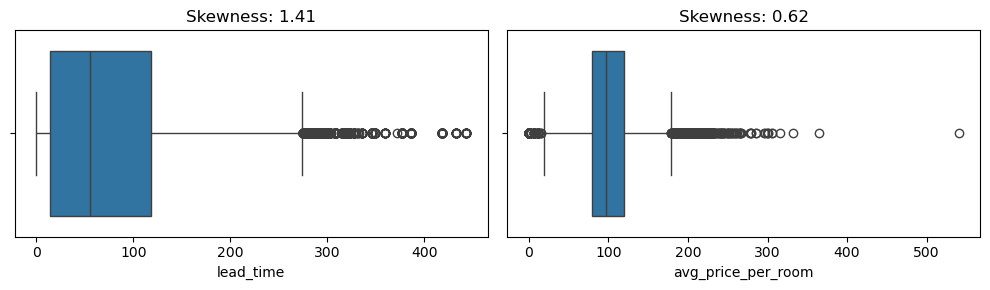

In [1331]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [1332]:
# Lets cap the extreme outliers
for i in num_cols:
    q1,q3 = np.quantile(past_data[i],[0.25,0.75])
    iqr = q3-q1
    ul,ll = q3+2.5*iqr,q1-2.5*iqr
    past_data[i]=past_data[i].apply(lambda x: ul if x>ul else 
                                    ll if x<ll else x)

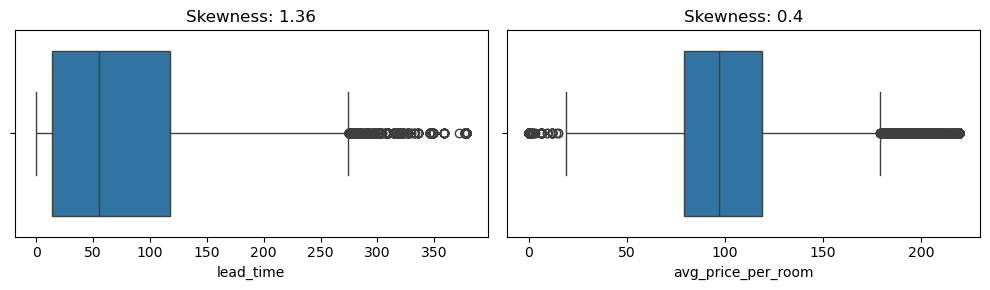

In [1333]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

### Feature Encoding

In [1334]:
past_data = pd.get_dummies(past_data,columns=['market_segment_type'],drop_first=True,dtype=int)

In [1335]:
new_data = pd.get_dummies(new_data,columns=['market_segment_type'],drop_first=True,dtype=int)

In [1336]:
# Let do ordinal encoding for booking status

past_data['booking_status'] = past_data['booking_status'].map({'Canceled':1,
                                                              'Not Canceled':0})

In [1337]:
new_data['booking_status'] = new_data['booking_status'].map({'Canceled':1,
                                                              'Not Canceled':0})

In [1338]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online
booking_id,,,,,,,,,,
INNHG_128127,4,1,103.0,1,0,2022-07-01,1,1,0,1
INNHG_128128,147,2,103.7,2,2,2022-07-01,0,2,0,1


### Feature Transformation

In [1339]:
transformer = PowerTransformer(standardize=False)

In [1340]:
past_data[num_cols] = transformer.fit_transform(past_data[num_cols])
new_data[num_cols] = transformer.transform(new_data[num_cols])

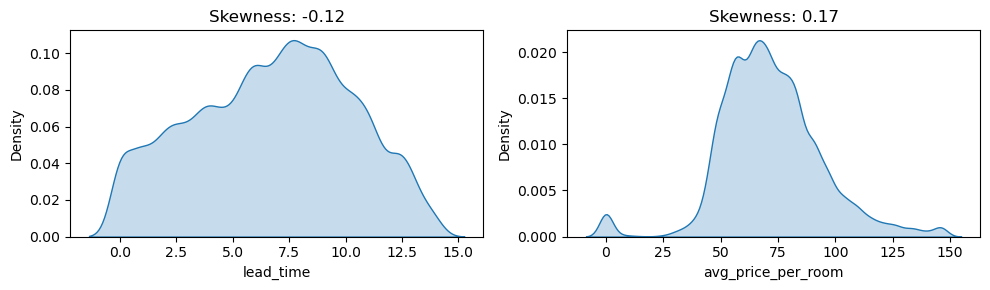

In [1341]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

### Feature Engineering (Generate new columns)

In [1342]:
# Lets extract month and weekday from date of arrival
past_data['arrival_month']=past_data['arrival_date'].dt.month
past_data['arrival_wkday']=past_data['arrival_date'].dt.weekday

In [1343]:
past_data.drop(columns='arrival_date',inplace=True)
past_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_101034,0.00000,0,61.729381,1,1,0,0,0,1,1,4
INNHG_101035,5.78447,2,87.801167,2,2,0,0,0,1,1,4


In [1344]:
new_data['arrival_month']=new_data['arrival_date'].dt.month
new_data['arrival_wkday']=new_data['arrival_date'].dt.weekday
new_data.drop(columns='arrival_date',inplace=True)

In [1345]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,0,1,7,4
INNHG_128128,10.093647,2,73.991462,2,2,0,2,0,1,7,4


In [1346]:
# We can add no of weekdays and weekdn in the booking and get stay duration
past_data['total_nights'] = past_data['no_of_week_nights'] + past_data['no_of_weekend_nights']

In [1347]:
new_data['total_nights'] = new_data['no_of_week_nights'] + new_data['no_of_weekend_nights']

In [1348]:
past_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights
booking_id,,,,,,,,,,,,
INNHG_101034,0.00000,0,61.729381,1,1,0,0,0,1,1,4,1
INNHG_101035,5.78447,2,87.801167,2,2,0,0,0,1,1,4,2


In [1349]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights
booking_id,,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,0,1,7,4,1
INNHG_128128,10.093647,2,73.991462,2,2,0,2,0,1,7,4,4


In [1350]:
# We can also calculate the departure weekday from total nights and arrival 
# weekday

In [1351]:
past_data['depart_wkday'] = past_data['arrival_wkday']+past_data['total_nights']

In [1352]:
new_data['depart_wkday'] = new_data['arrival_wkday']+new_data['total_nights']

In [1353]:
def setting_weekday(num):
    if num>6:
        return num%7
    else:
        return num

In [1354]:
past_data['depart_wkday'] = past_data['depart_wkday'].apply(setting_weekday)
new_data['depart_wkday'] = new_data['depart_wkday'].apply(setting_weekday)

In [1355]:
past_data.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,0,0,0,1,1,4,1,5
INNHG_101035,5.784470,2,87.801167,2,2,0,0,0,1,1,4,2,6
INNHG_101036,4.986923,1,52.818520,2,2,0,0,0,1,1,4,2,6
INNHG_101037,4.894729,0,61.510571,1,2,0,0,0,1,1,4,2,6
INNHG_101038,6.541683,1,103.222808,2,2,0,3,1,1,1,4,5,2


In [1356]:
past_data.shape

(27093, 13)

In [1357]:
new_data.shape

(3583, 13)

# Predictive Modeling

In [1358]:
# Libaries 
from sklearn.metrics import (accuracy_score,f1_score,recall_score,precision_score,classification_report,cohen_kappa_score,roc_curve,roc_auc_score)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model  import LogisticRegression #Baseline Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [1359]:
y_train = past_data['booking_status']
x_train = past_data.drop(columns=['booking_status'])
y_test = new_data['booking_status']
x_test = new_data.drop(columns=['booking_status'])

In [1360]:
print(x_train.shape,y_train.shape,y_test.shape,x_test.shape)

(27093, 12) (27093,) (3583,) (3583, 12)


In [1361]:
# Create to function to train predict and validate the models

def model_training(model,xtrain=x_train,ytrain=y_train,xtest=x_test,cutoff=0.5):
    m = model 
    m.fit(xtrain,ytrain)
    pred_s = m.predict_proba(xtest)[:,1]
    pred_h = (pred_s>cutoff).astype(int)

    return pred_s,pred_h

In [1362]:
def model_scores(predh,preds,ytest=y_test):
    print('Classification Report:\n',classification_report(ytest,predh))
    

    fpr,tpr,thres = roc_curve(ytest,predh)

    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],ls='--',color='red')
    plt.title(f'ROC AUC: {round(roc_auc_score(ytest,preds),2)}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()


In [1363]:
# Function for model Tuning

def model_tuning(model,grid,x=x_train,y=y_train,folds=6,score='roc_auc'):
    gscv = GridSearchCV(estimator=model,param_grid=grid,cv=folds,verbose=0,scoring=score)

    gscv.fit(x,y)
    print('Best Score :',gscv.best_score_)
    return gscv.best_params_

In [1364]:
# Function for scorecard 

mod =[]
accu = []
rec = []
pre = [] 
f1= []
ck = []
auc = []


def model_scorecard(model_name,predh,preds,ytest=y_test):
    mod.append(model_name)
    accu.append(accuracy_score(ytest,predh))
    rec.append(recall_score(ytest,predh))
    pre.append(precision_score(ytest,predh))
    f1.append(f1_score(ytest,predh))
    ck.append(cohen_kappa_score(ytest,predh))
    auc.append(roc_auc_score(ytest,preds))
    global scorecard



    scorecard = pd.DataFrame({'Accuracy':accu,'Recall':rec,'Precision':pre,'F1 Score':f1,'Cohen-Kappa Score':ck,'ROC Auc':auc},index=mod)

    return scorecard



# Logistic Regression (Baseline Model)

In [1365]:
ypred_lr_s,ypred_lr_h = model_training(LogisticRegression())

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86      2383
           1       0.78      0.54      0.64      1200

    accuracy                           0.79      3583
   macro avg       0.79      0.73      0.75      3583
weighted avg       0.79      0.79      0.78      3583



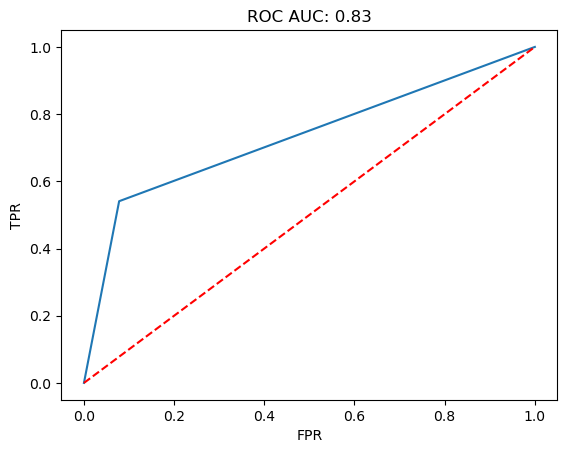

In [1366]:
model_scores(ypred_lr_h,ypred_lr_s,ytest=y_test)

In [1367]:
model_scorecard('Log Reg (Base Model)',ypred_lr_h,ypred_lr_s,y_test)

,Accuracy,Recall,Precision,F1 Score,Cohen-Kappa Score,ROC Auc
Log Reg (Base Model),0.794306,0.540833,0.777246,0.637838,0.500573,0.834945


#  Decision Tree

In [1368]:
grid = {'max_depth':[4,5,6,7,8,9]}

best_params = model_tuning(DecisionTreeClassifier(class_weight='balanced'),grid)

Best Score : 0.7671326079084433


In [1369]:
ypred_dt_s,ypred_dt_h = model_training(DecisionTreeClassifier(class_weight='balanced',**best_params))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      2383
           1       0.75      0.70      0.73      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.79      0.80      3583
weighted avg       0.82      0.82      0.82      3583



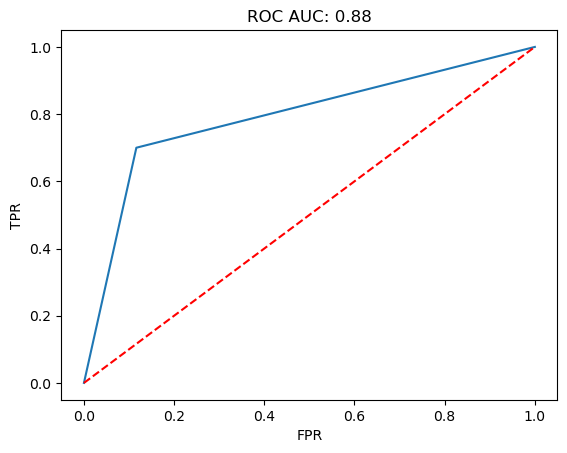

In [1370]:
model_scores(ypred_dt_h,ypred_dt_s)

In [1371]:
model_scorecard('Decision Tree',ypred_dt_h,ypred_dt_s)

,Accuracy,Recall,Precision,F1 Score,Cohen-Kappa Score,ROC Auc
Log Reg (Base Model),0.794306,0.540833,0.777246,0.637838,0.500573,0.834945
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697


In [1372]:
scorecard

,Accuracy,Recall,Precision,F1 Score,Cohen-Kappa Score,ROC Auc
Log Reg (Base Model),0.794306,0.540833,0.777246,0.637838,0.500573,0.834945
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697


In [1373]:
# Random Forest (Bagging)

In [1374]:
grid = {'n_estimators':[70,100,120,150,180,200],
        'max_depth':[3,4,5,6]}

best_params= model_tuning(RandomForestClassifier(class_weight='balanced'),grid)

Best Score : 0.8103312667748647


In [1375]:
ypred_rf_s,ypred_rf_h = model_training(RandomForestClassifier(class_weight='balanced',**best_params))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      2383
           1       0.68      0.65      0.66      1200

    accuracy                           0.78      3583
   macro avg       0.75      0.75      0.75      3583
weighted avg       0.78      0.78      0.78      3583



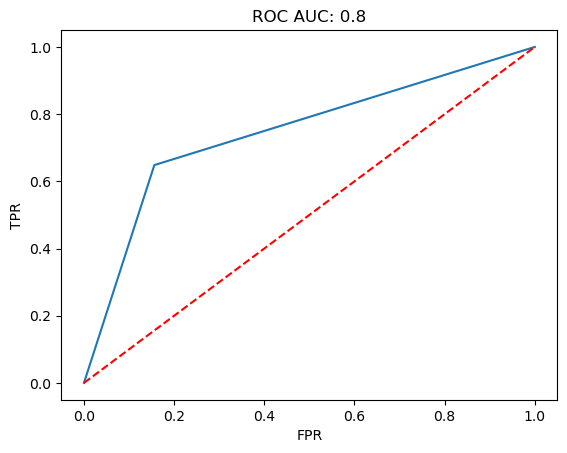

In [1376]:
model_scores(ypred_rf_h,ypred_rf_s)

In [1377]:
model_scorecard('Random Forest',ypred_rf_h,ypred_rf_s)

,Accuracy,Recall,Precision,F1 Score,Cohen-Kappa Score,ROC Auc
Log Reg (Base Model),0.794306,0.540833,0.777246,0.637838,0.500573,0.834945
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697
Random Forest,0.778398,0.648333,0.676522,0.662128,0.497372,0.798597


In [1378]:
scorecard

,Accuracy,Recall,Precision,F1 Score,Cohen-Kappa Score,ROC Auc
Log Reg (Base Model),0.794306,0.540833,0.777246,0.637838,0.500573,0.834945
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697
Random Forest,0.778398,0.648333,0.676522,0.662128,0.497372,0.798597


### XGBoost

In [1379]:
grid = {'max_depth':[5,6,7],'learning_rate':[0.01,0.02,0.05,0.07],'n_estimators':[70,100,120,150,180,200]}
best_params = model_tuning(XGBClassifier(class_weights='balanced'),grid)

Best Score : 0.7827617718209501


In [1380]:
ypred_XGB_s,ypred_XGB_h = model_training(XGBClassifier(class_weights='balanced',**best_params))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      2383
           1       0.91      0.55      0.68      1200

    accuracy                           0.83      3583
   macro avg       0.86      0.76      0.78      3583
weighted avg       0.84      0.83      0.82      3583



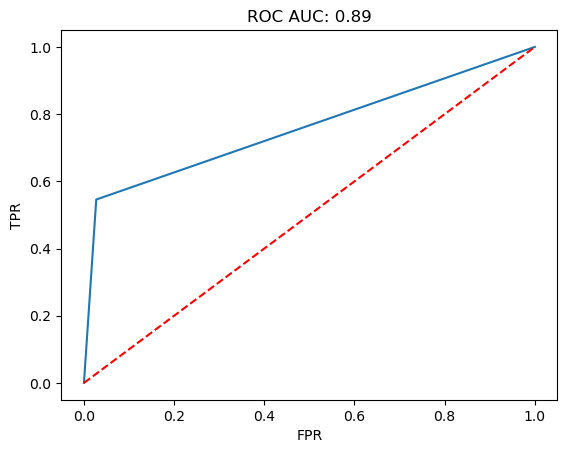

In [1381]:
model_scores(ypred_XGB_h,ypred_XGB_s)

In [1382]:
model_scorecard('XGB Boost',ypred_XGB_h,ypred_XGB_s)

,Accuracy,Recall,Precision,F1 Score,Cohen-Kappa Score,ROC Auc
Log Reg (Base Model),0.794306,0.540833,0.777246,0.637838,0.500573,0.834945
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697
Random Forest,0.778398,0.648333,0.676522,0.662128,0.497372,0.798597
XGB Boost,0.829752,0.545833,0.909722,0.682292,0.575718,0.888700


In [1383]:
scorecard

,Accuracy,Recall,Precision,F1 Score,Cohen-Kappa Score,ROC Auc
Log Reg (Base Model),0.794306,0.540833,0.777246,0.637838,0.500573,0.834945
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697
Random Forest,0.778398,0.648333,0.676522,0.662128,0.497372,0.798597
XGB Boost,0.829752,0.545833,0.909722,0.682292,0.575718,0.888700


# Final Model 

In [1384]:
#Lets Explore XGBoost 

model_XGB = XGBClassifier(n_estimators=100,max_depth=7,learning_rate=0.01)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90     18236
           1       0.88      0.66      0.75      8857

    accuracy                           0.86     27093
   macro avg       0.86      0.81      0.83     27093
weighted avg       0.86      0.86      0.85     27093



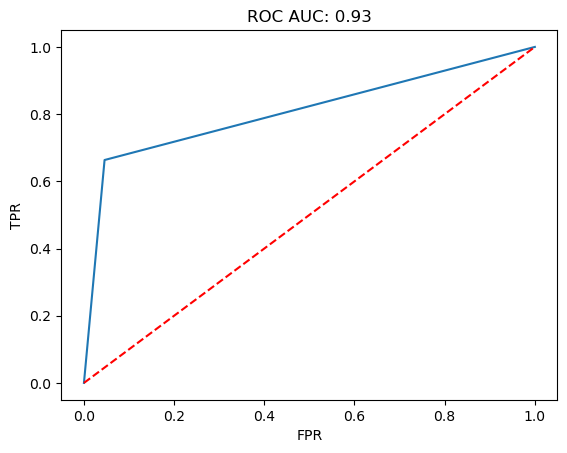

In [1385]:
# Train Score

ypred_xgb_s , ypred_xgb_h = model_training(model_XGB,xtest=x_train)
model_scores(ypred_xgb_h,ypred_xgb_s,ytest=y_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      2383
           1       0.84      0.64      0.73      1200

    accuracy                           0.84      3583
   macro avg       0.84      0.79      0.81      3583
weighted avg       0.84      0.84      0.83      3583



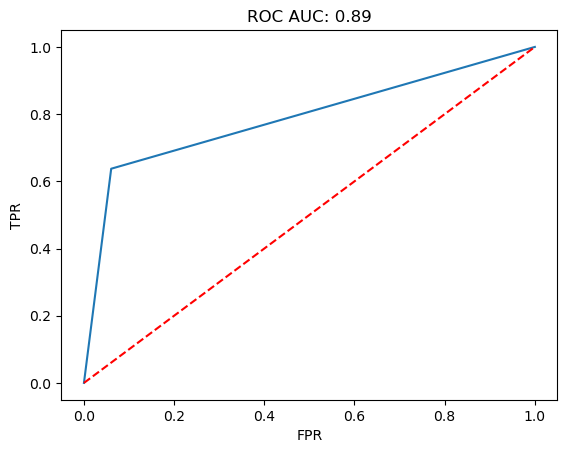

In [1386]:
 # Test Score

ypred_xgb_s , ypred_xgb_h = model_training(model_XGB,xtest=x_test)
model_scores(ypred_xgb_h,ypred_xgb_s,ytest=y_test)

In [1387]:
# Lets See Decision Tree

model_dt = DecisionTreeClassifier(max_depth=7)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     18236
           1       0.79      0.76      0.77      8857

    accuracy                           0.86     27093
   macro avg       0.84      0.83      0.83     27093
weighted avg       0.85      0.86      0.85     27093



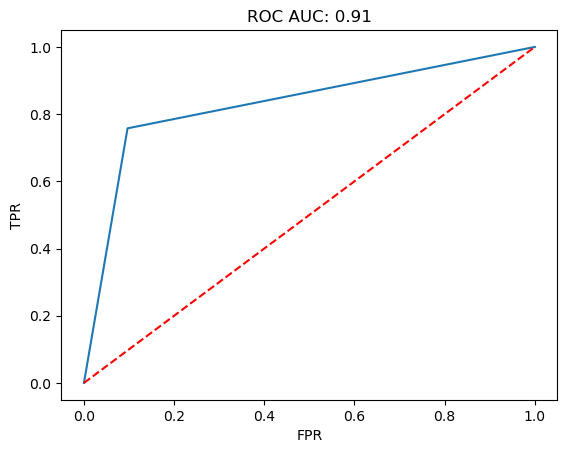

In [1388]:
# Train Score

ypred_dt_s , ypred_dt_h = model_training(model_dt,xtest=x_train)
model_scores(ypred_dt_h,ypred_dt_s,ytest=y_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      2383
           1       0.78      0.69      0.73      1200

    accuracy                           0.83      3583
   macro avg       0.81      0.80      0.80      3583
weighted avg       0.83      0.83      0.83      3583



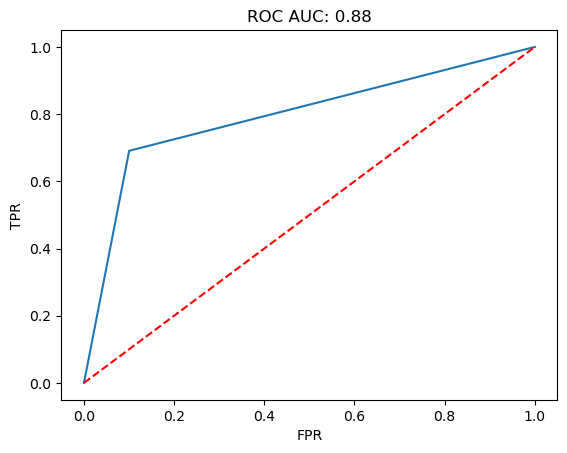

In [1389]:
# Test Score

ypred_dt_s , ypred_dt_h = model_training(model_dt,xtest=x_test)
model_scores(ypred_dt_h,ypred_dt_s,ytest=y_test)

In [1390]:
# Lets Try Voting in order to combine both the models

from sklearn.ensemble import VotingClassifier

In [ ]:
model_vote = VotingClassifier(estimators=[('DecisionTree',model_dt),('XGB',model_XGB)],voting='soft')


In [ ]:
model_vote.fit(x_train,y_train)

In [1404]:
fpr,tpr,thres = roc_curve(y_test,ypred_vote_s)
pd.DataFrame({'FPR':fpr,
              'TPR':tpr,
              'Thres':thres,
              'YI':tpr*(1-fpr)}).sort_values(by='YI',ascending=False).head(2)

,FPR,TPR,Thres,YI
225,0.154008,0.789167,0.294319,0.667629
224,0.152749,0.787500,0.295261,0.667210


In [1405]:
model_vote.fit(x_train,y_train)
ypred_vote_s  = model_vote.predict_proba(x_test)[:,1]
ypred_vote_h  = (ypred_vote_s>=0.3).astype(int)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      2383
           1       0.72      0.78      0.75      1200

    accuracy                           0.83      3583
   macro avg       0.80      0.81      0.81      3583
weighted avg       0.83      0.83      0.83      3583



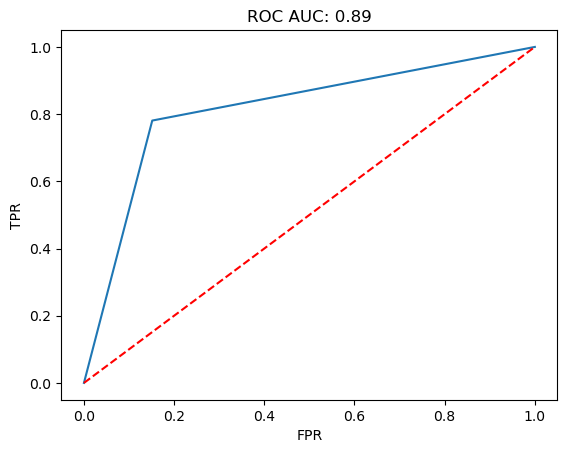

In [1406]:
model_scores(ypred_vote_h,ypred_vote_s)

## Deployment 

In [1408]:
x_train.columns

Index(['lead_time', 'no_of_special_requests', 'avg_price_per_room',
       'no_of_adults', 'no_of_weekend_nights', 'required_car_parking_space',
       'no_of_week_nights', 'market_segment_type_Online', 'arrival_month',
       'arrival_wkday', 'total_nights', 'depart_wkday'],
      dtype='object')

In [1410]:
lt = 15
spcl = 0
price = 120 
adul = 2 
wkend = 2
park = 0 
wk =1 
mrkt =1
amnth = 10
awk = 3 
tn = 3 
dw = 5

In [1411]:
lt_t,price_t = transformer.transform([[lt,price]])[0]
lt_t,price_t

(np.float64(4.029223743671129), np.float64(84.53117877205352))

In [1412]:
input_list = [lt_t,spcl,price_t,adul,wkend,park,wk,mrkt,amnth,awk,tn,dw]

In [1413]:
model_vote.predict_proba([input_list])[:,1]

array([0.1300378])

In [1415]:
# So we need all these above instances for deployment. Lets create joblib file 
import joblib 

In [1416]:
with open('transformer.joblib','wb') as file:
    joblib.dump(transformer,file)

In [1417]:
with open('final_model.joblib','wb') as file:
    joblib.dump(model_vote,file)

In [1418]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
